# Probabilistic Topic Models

** Steyvers & Griffiths (2004) **

In [3]:
from IPython.display import display, Image

### A. Model in a Nutshell

** Model **

**NB: ** SG04 annotate *topic* with $z$ and $t$ interchangeably. We are sticking to $j$ and $t$, as I am personally used to the latter annotation..

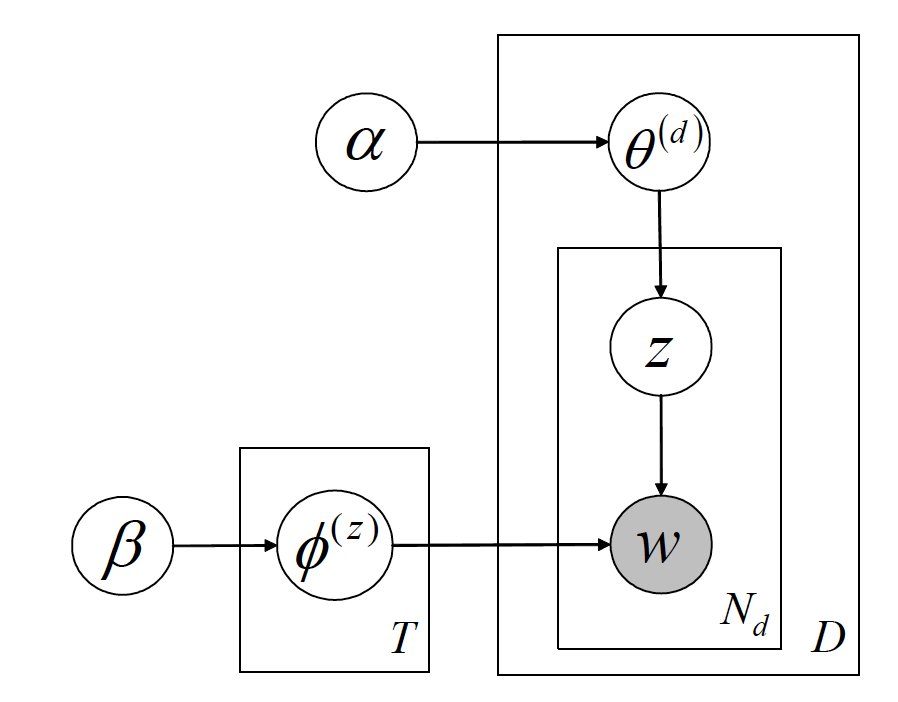

In [6]:
display(Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/LDA/FIGS/SG04_model.png',width='30%'))

** Math **

$\begin{align} P(w_i,t_j) &= P(w_i,t_j|\mathbf{w}_{-i},d_i,\cdot) \\ &\propto P(w_i|z_j)\cdot P(z_j|d_i) \\ &= \phi^{t_j}\cdot\theta^{d_i} \\ &\propto \frac{C_{w_i,t_j}^{WT} + \beta}{\sum_{w=1}^WC_{w_i,t_j}^{WT} + W\beta} \cdot \frac{C_{d_i,t_j}^{DT} + \alpha}{\sum_{t=1}^TC_{d_i,t_j}^{DT} + T\alpha} \end{align}$

**Interpretation**

* The probability of a word $w_i$ being assigned a topic $t$ (i.e. $P(w_i,t_j)$) is proportional to the product of the probability of having a word $w_i$ given $t_j$ (i.e. $P(w_i|z_j)$) and the probability of a topic $t_j$ being assigned to the word in a particular document $d_i$ (i.e. $P(z_j|d_i)$).
    * Note: $d_i$ does NOT mean *the $i$th document*, it instead means the document where $w_i$ is instantiated, since we are iterating over all words. Therefore $d_i$ can be read as *the current document*.
        
* $\cdot$: various observed information (e.g. the current assigned topic distributions).
    
* $\phi^{t_j}$: The multinomial distribution over all words for topic $t_j$.
    
* $\theta^{d_i}$: The multinomial distribution over topics for document $d_i$.
    
* $\mathbf{C}^{WT}$, $\mathbf{C}^{DT}$: The matrix of counts (dim: $W\times T$ and $D\times T$).
    
* $C_{w_i,t_j}^{WT}$: The number of times a word $w_i$ is assigned to the topic $t_j$, *not including the current instance of $w_i$*.      
    
* $C_{d_i,t_j}^{DT}$: The number of ties topic $t_j$ is assigned to some word token in document $d_i$, *again not including the current instance of $w_i$*.

**How Word/Topic Distribution Change**

* "Once many tokens of a word have been assigned to topic $j$ (across documents), it will increase the probability of assigning any particular token of that word to topic $j$. At the same time, if topic $j$ has been used multiple times in one document, it will increase the probability that any word from that document will be assigned to topic $j$. Therefore, words are assigned to topics depending on how likely the word is for a topic, as well as how dominant a topic is in a document." (cf. SG04:8)

### B. Toy Example

**Setup:**
* 5-word vocabulary: *river*, *stream*, *bank*, *money* and *loan*.
* 15 documents of three types (each type is represented by 5 documents): *Mixed*, *Single-Financial*, *Single-Scenery*.
    * Single-Financial: only contains words from the vocabulary {*bank*,*money*,*loan*} with uniform distribution (i.e. $\frac{1}{3}$ for each word to appear).
    * Single-Scenery: only contains words from the vocabulary {*river*,*stream*} with uniform distribution.
    * Mixed: contains words from the entire vocabulary with uniform distribution.
* Each document has 20 words.

In [567]:
import random
import numpy as np
from collections import Counter
import math
from operator import add, mul

In [660]:
def generate_documents():
    
    financial_vocab = ['bank','money','loan']
    scenery_vocab = ['river','stream']
    vocab = financial_vocab + scenery_vocab
    
    topic = lambda: 1 if random.uniform(0,1)>.5 else 0 
    
    documents = []
    
    documents += [[(random.choice(financial_vocab),topic()) for _ in xrange(20)] for _ in xrange(5)]
    documents += [[(random.choice(scenery_vocab),topic()) for _ in xrange(20)] for _ in xrange(5)]
    documents += [[(random.choice(vocab),topic()) for _ in xrange(20)] for _ in xrange(5)]
    
    return documents

In [661]:
documents = generate_documents() # a list of documents which are in the format [(word,topic),...].

In [578]:
import matplotlib.pyplot as plt
%matplotlib inline

In [579]:
def summarize_documents(documents):
    fc, ft = lambda d: [w for w,t in d], lambda d: [t for w,t in d]
    get_counts = lambda ds,f: Counter(reduce(add,map(f,ds)))
    c_financial, c_scenery, c_mixed = get_counts(documents[:5],fc), \
                                      get_counts(documents[5:10],fc), get_counts(documents[10:],fc)
    t_financial, t_scenery, t_mixed = get_counts(documents[:5],ft), \
                                      get_counts(documents[5:10],ft), get_counts(documents[10:],ft)
    CT = [c_financial,c_scenery,c_mixed,t_financial,t_scenery,t_mixed]
    print 'WORD & TOPIC COUNTS'
    plt.subplots(figsize=(12,4))
    for i in xrange(6):
        plt.subplot(230+i+1)
        color = 'blue' if i<3 else 'grey'
        plt.bar(np.arange(len(CT[i])),CT[i].values(),width=.7,align='center',color=color)
        plt.ylim((0,100))
        plt.xticks(np.arange(len(CT[i])) + .7*.05, CT[i].keys())  
    plt.show()

WORD & TOPIC COUNTS


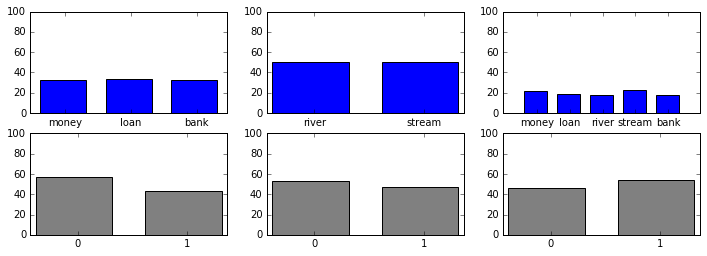

In [580]:
summarize_documents(documents)

In [581]:
print documents[0]
print len(documents)

[('loan', 1), ('loan', 0), ('bank', 0), ('bank', 0), ('money', 0), ('bank', 0), ('bank', 0), ('bank', 1), ('loan', 1), ('loan', 1), ('loan', 0), ('loan', 0), ('bank', 0), ('money', 1), ('loan', 0), ('loan', 1), ('bank', 1), ('money', 0), ('bank', 1), ('bank', 0)]
15


In [582]:
from __future__ import division

In [583]:
alpha, beta = 50/2, .001 # cf. SG04:5.

In [584]:
vocab = list(set(reduce(add,map(lambda d: [w for w,t in d], documents))))
w2i = {w:i for i,w in enumerate(vocab)}
topics = [0,1]
W = len(vocab)
D, T = len(documents), len(topics)

In [585]:
def get_counts(documents):
    C_WT, C_DT = np.zeros((W,T)), np.zeros((D,T))
    wt_counts = reduce(add,[Counter(d) for d in documents])
    for (w,t),count in wt_counts.iteritems():
        C_WT[w2i[w]][t] = count
    for i,d in enumerate(documents):
        dt_counts = Counter([t for w,t in d]) # format: Counter({0: count1, 1: count2}).
        for j in xrange(T):
            C_DT[i][j] = dt_counts[j]
    return C_WT, C_DT    

In [586]:
C_WT, C_DT = get_counts(documents)

In [587]:
print pd.DataFrame(C_WT,index=vocab)
print pd.DataFrame(C_DT)

           0     1
money   28.0  27.0
loan    24.0  29.0
river   41.0  27.0
stream  36.0  37.0
bank    27.0  24.0
       0     1
0   12.0   8.0
1   12.0   8.0
2   10.0  10.0
3    9.0  11.0
4   14.0   6.0
5    9.0  11.0
6   12.0   8.0
7   11.0   9.0
8   12.0   8.0
9    9.0  11.0
10  10.0  10.0
11  11.0   9.0
12   7.0  13.0
13  10.0  10.0
14   8.0  12.0


In [588]:
def sample_topic(i,j,d): # i,j,d: indices of word, topic and document
    # compute normalizing constant
    Z = sum( ((C_WT[i][k]+beta) / (sum(C_WT[w][k] for w in xrange(W))+W*beta)) * \
             ((C_DT[d][k]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) 
            for k in xrange(T)) 
        # w: temp var for word, over all words.
        # t,k: temp vars for topic, over all topics.
    P = [( ((C_WT[i][j]+beta) / (sum(C_WT[w][j] for w in xrange(W))+W*beta)) * \
           ((C_DT[d][j]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) ) / Z
          for j in xrange(T)]
    return np.random.choice(np.array(topics),p=np.array(P))

In [589]:
# GIBBS
C_WT, C_DT = get_counts(documents)
for _ in xrange(64):
    for d,doc in enumerate(documents):
        for idx,(i,j) in enumerate(doc): # doc: [(w_i,t_j), ...]
            C_WT[w2i[i]][j] -= 1
            C_DT[d][j] -= 1
            new_topic = sample_topic(w2i[i],j,d) # w2i: look up word's index.
            doc[idx] = (i,new_topic)
            C_WT[w2i[i]][new_topic] += 1
            C_DT[d][new_topic] += 1

In [590]:
print pd.DataFrame(C_WT,index=vocab)
print pd.DataFrame(C_DT) 

           0     1
money    0.0  55.0
loan     0.0  53.0
river   68.0   0.0
stream  73.0   0.0
bank     0.0  51.0
       0     1
0    0.0  20.0
1    0.0  20.0
2    0.0  20.0
3    0.0  20.0
4    0.0  20.0
5   20.0   0.0
6   20.0   0.0
7   20.0   0.0
8   20.0   0.0
9   20.0   0.0
10  10.0  10.0
11   8.0  12.0
12   6.0  14.0
13   9.0  11.0
14   8.0  12.0


WORD & TOPIC COUNTS


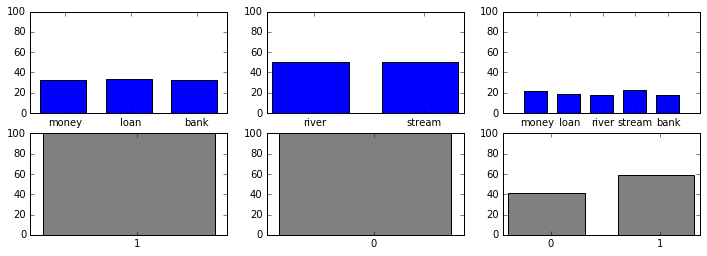

In [591]:
summarize_documents(documents)

### C. Gibbs Sampling ("Real World" Tryout: Brown Corpus)

** Setup **

* Topic Selection: Government, Hobbies (encoding: topic 0, 1).
* Documents: 3 documents (10000 words per document) with the following topic mixing:
    * Single-Topic Documents: 0, 1.
    * Bi-Topic Documents: maxent mixing.
* Confounder: Give the model 3 topic labels, and see if it knows there are actually only 2.
    
** Comments **

* The model works also on the toy data I have generated, which has 2 sets of clearly defined "topic words".
* On the "natural dataset", the model seems to have figured out there are 2 topics (or, more properly put, 2 bags of distinctive words) over the entire document set.
* However, it failed to distinguish documents by topic.

In [593]:
import random
import numpy as np
from nltk.corpus import brown, stopwords
from nltk.stem import PorterStemmer
from string import punctuation
from itertools import combinations
from collections import Counter
from copy import deepcopy
from operator import add, mul
from __future__ import division

In [594]:
import matplotlib.pyplot as plt
%matplotlib inline

In [639]:
import cPickle

In [793]:
def preprocessing(corpus, subset_size): # corpus: a list of words.
    # NB: empirically, doing everything in one-liners is slow.
    # lowercasing, stripping punctuations.
    corpus = [w.lower() for w in corpus if w not in punctuation
                                        and w not in ["``","''","--"]] # special monkey wrenches in brown.]
    # stemming 
    corpus = [PorterStemmer().stem(w) for w in corpus if w not in stopwords.words()]
    freq_dist = Counter(corpus)
    # stripping infrequent words
    corpus = [w for w in corpus if freq_dist[w] > 1]
        # alternative approach: subset = map(lambda (w,c): w, 
        #                                    Counter(corpus).most_common(subset_size))
    subset = random.sample(corpus, subset_size)
    return subset
def load_documents(subset_size=10000):
    corpus = {}
    topics = ['government','hobbies']
    print "... extracting and preprocessing corpus"
    for t in topics:
        corpus[t] = preprocessing(brown.words(categories=t),subset_size)
    print "... creating documents"
    documents = []
    # single-topic documents
    documents.extend([corpus['government'],corpus['hobbies']])
    # bi-topic documents
    for t_i,t_j in combinations(topics,2):
        sample = random.sample(corpus[t_i],int(subset_size/2)) + \
                 random.sample(corpus[t_j],int(subset_size/2))
        documents.append(sample)                       
    return documents

In [802]:
%%time
documents = load_documents()

... extracting and preprocessing corpus
... creating documents
CPU times: user 2min 17s, sys: 18.5 s, total: 2min 35s
Wall time: 2min 36s


In [803]:
data_folder = '/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/LDA/DATA/'
cPickle.dump(documents, open(data_folder+'brown_government_hobbies.p', 'wb')) 
# documents = cPickle.load(open(data_folder+'brown_government_hobbies.p', 'rb'))

In [914]:
class TopicModel:
    
    def __init__(self, documents, num_topics=3, num_iters=100):
        self.topics = np.arange(num_topics)
        self.documents = self.__initialize_topics(deepcopy(documents))
        self.__gibbs(num_iters)
    
    def __initialize_topics(self, documents):
        for document in documents:
            for i,word in enumerate(document):
                document[i] = (word, random.choice(self.topics))
        return documents
    
    def __get_counts(self,W,D,T,w2i):
        C_WT, C_DT = np.zeros((W,T)), np.zeros((D,T))
        wt_counts = reduce(add,[Counter(d) for d in self.documents])
        for (w,t),count in wt_counts.iteritems():
            C_WT[w2i[w]][t] = count
        for i,d in enumerate(self.documents):
            dt_counts = Counter([t for w,t in d]) # format: Counter({0: count1, 1: count2}).
            for j in xrange(T):
                C_DT[i][j] = dt_counts[j]
        return C_WT, C_DT 
    
    def __sample_topic(self,i,j,d,C_WT,C_DT): # i,j,d: indices of word, topic and document
        # compute normalizing constant
        Z = sum( ((C_WT[i][k]+beta) / (sum(C_WT[w][k] for w in xrange(W))+W*beta)) * \
                 ((C_DT[d][k]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) 
                for k in xrange(T)) 
            # w: temp var for word, over all words.
            # t,k: temp vars for topic, over all topics.
        P = [( ((C_WT[i][j]+beta) / (sum(C_WT[w][j] for w in xrange(W))+W*beta)) * \
               ((C_DT[d][j]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) ) / Z
              for j in xrange(T)]
        return np.random.choice(np.array(topics),p=np.array(P))    
    
    def __gibbs(self, num_iters):
        alpha, beta = 50/len(self.topics), .001 
            # empirically, the original setup doesn't work as well as the one here 
            #  (cf. SG04:5,α =50/T and β = 0.01).
        vocab = list(set(reduce(add,map(lambda d: [w for w,t in d],
                                        self.documents))))       
        w2i = {w:i for i,w in enumerate(vocab)} # w2i: look up word's index.
        W = len(vocab)
        D, T = len(self.documents), len(self.topics)
        C_WT, C_DT = self.__get_counts(W,D,T,w2i)
        for _ in xrange(num_iters):
            for d,doc in enumerate(self.documents):
                for idx,(i,j) in enumerate(doc): # doc: [(w_i,t_j), ...]
                    C_WT[w2i[i]][j] -= 1
                    C_DT[d][j] -= 1
                    new_topic = self.__sample_topic(w2i[i],j,d,C_WT,C_DT) 
                    doc[idx] = (i,new_topic)
                    C_WT[w2i[i]][new_topic] += 1
                    C_DT[d][new_topic] += 1
        self.c_wt_table = pd.DataFrame(C_WT,index=vocab)
        self.c_dt_table = pd.DataFrame(C_DT)
            
    def summarize(self, k=5, figsize=(10,4)):
        # keep top-k frequent words
        top_k_vocab = lambda doc: map(lambda (w,t): w, 
                                      Counter([w for w,t in doc]).most_common(k))
        get_top_k = lambda doc,vocab: [(w,t) for w,t in doc if w in vocab]
        documents = deepcopy(self.documents) # avoid modifying the original.
        for i,document in enumerate(documents):
            vocab = top_k_vocab(document)
            documents[i] = get_top_k(document,vocab)
        # count words & topics
        word_counts = lambda d: Counter([w for w,t in d])
        topic_counts = lambda d: Counter([t for w,t in d]) 
        num_docs = len(documents)
        word_dists, topic_dists = [], []
        for document in documents:
            word_dists.append(word_counts(document))
            topic_dists.append(topic_counts(document))
        # plotting
        print "WORD & TOPIC COUNTS"
        ylim = max(len(d) for d in documents)
        width = .7
        plt.subplots(figsize=figsize)
        for i in xrange(len(documents)*2):
            plt.subplot(2,len(documents),i+1)
            plt.ylim(0,ylim)
            if i < len(documents):
                plt.bar(np.arange(len(word_dists[i])),word_dists[i].values(),
                        width=width,align='center',color='blue')
                plt.xticks(np.arange(len(word_dists[i]))+width*.05, 
                           word_dists[i].keys())
            else:
                plt.bar(np.arange(len(topic_dists[i-len(documents)])),
                        topic_dists[i-len(documents)].values(),
                        width=width,align='center',color='grey')
                plt.xticks(np.arange(len(topic_dists[i-len(documents)]))+width*.005, 
                           topic_dists[i-len(documents)].keys()) 
        plt.show()
    

##### TEST RUN ON TOY DATA

In [842]:
def generate_documents(): 
    # different from the previous version,
    #  this one only generates lists of words.
    financial_vocab = ['bank','money','loan']
    scenery_vocab = ['river','stream']
    vocab = financial_vocab + scenery_vocab      
    documents = []   
    documents += [[random.choice(financial_vocab) for _ in xrange(20)] for _ in xrange(5)]
    documents += [[random.choice(scenery_vocab) for _ in xrange(20)] for _ in xrange(5)]
    documents += [[random.choice(vocab) for _ in xrange(20)] for _ in xrange(5)]   
    return documents
documents = generate_documents()

In [843]:
tm = TopicModel(documents, num_iters=500)

WORD & TOPIC COUNTS


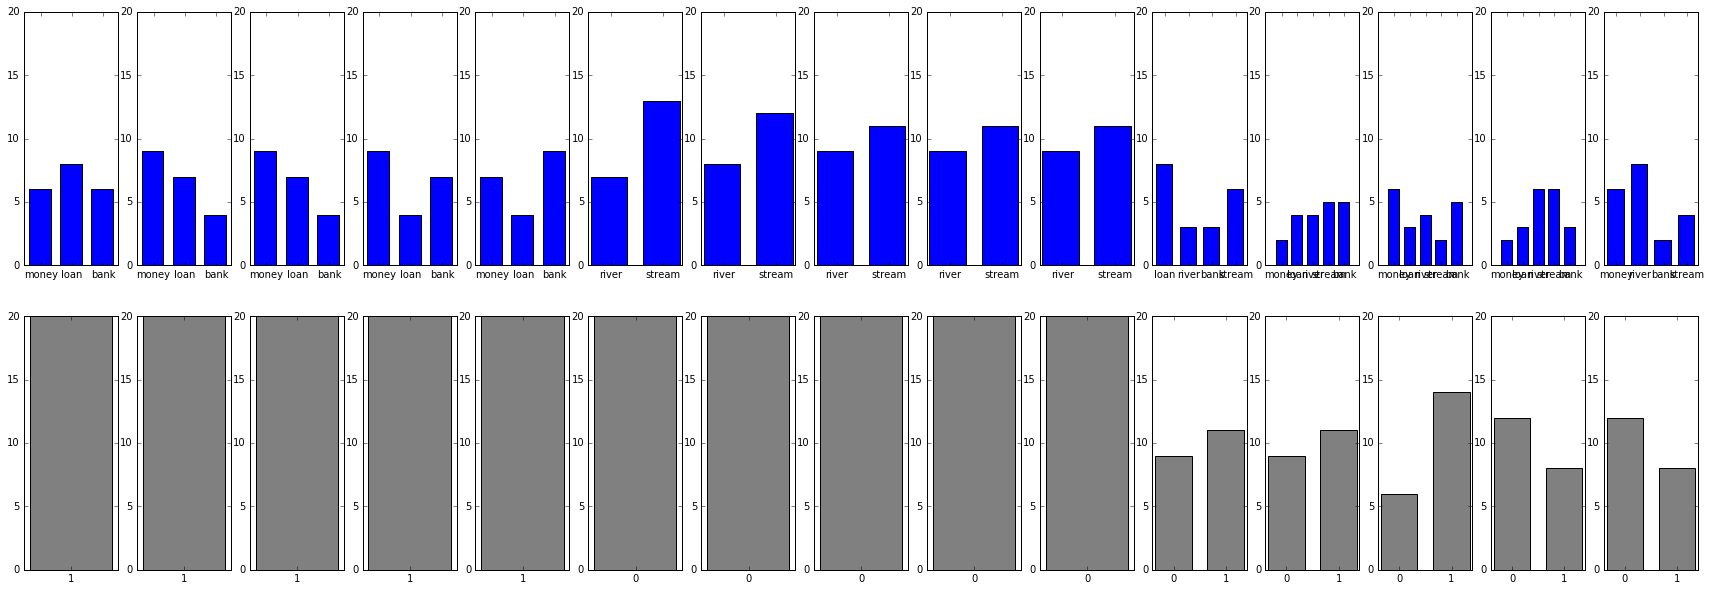

In [844]:
tm.summarize(figsize=(30,10))

##### "REAL THING"

In [915]:
documents = cPickle.load(open(data_folder+'brown_government_hobbies.p', 'rb'))

In [916]:
%%time
tm = TopicModel(documents, num_iters=200)

CPU times: user 5min 22s, sys: 3.28 s, total: 5min 25s
Wall time: 5min 25s


WORD & TOPIC COUNTS


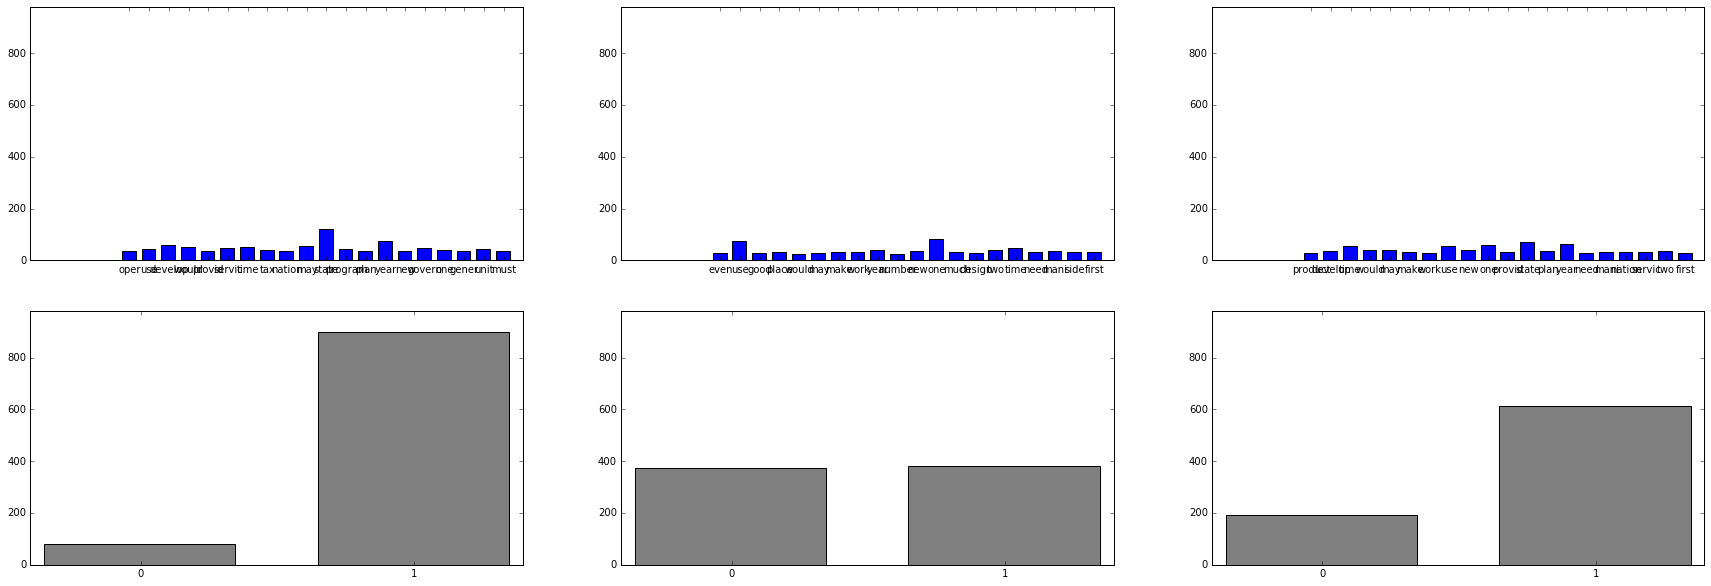

In [917]:
tm.summarize(k=20,figsize=(30,10))

### D. Collapsed Gibbs Sampling (Gensim)

** NB: Mallet Wrapper for Python (cf. https://radimrehurek.com/gensim/models/ldamallet.html) **
** NB: The setup is exactly the same as in section C. **

** Comments **

* 3-Topic Test: If the "correct number of source topics" (in this case, 2, 'government' and 'hobbies'), the model gets somewhat confused. However, it manages to give single-topic 'government' and 'hobbies' documents skewed distribution of topics and the bi-topic document a more even distribution over topics.
* 2-Topic Test: The model works well in the 2-topic treatment.

In [868]:
from gensim import corpora
from gensim.models.wrappers import LdaMallet

##### a. 3-Topic Test

In [869]:
dic = corpora.Dictionary(documents)
corpus = [dic.doc2bow(document) for document in documents]

In [870]:
%%time
path = '/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/LDA/PACKAGES/mallet-2.0.7/bin/mallet'
lda = LdaMallet(path, corpus=corpus, num_topics=3, id2word=dic)

CPU times: user 437 ms, sys: 17.8 ms, total: 455 ms
Wall time: 36.9 s


In [902]:
lda.print_topics(num_topics=3,num_words=5)

[u'0.018*state + 0.015*year + 0.012*develop + 0.010*unit + 0.009*nation',
 u'0.012*make + 0.010*design + 0.009*time + 0.008*engin + 0.008*cut',
 u'0.011*work + 0.008*requir + 0.006*american + 0.006*market + 0.006*good']

In [900]:
for i in lda.load_document_topics():
    print i

[(0, 0.6403980536348005), (1, 0.0472688691325504), (2, 0.31233307723264914)]
[(0, 0.16346732911773562), (1, 0.4535531466425775), (2, 0.38297952423968684)]
[(0, 0.4120478359065497), (1, 0.24721389166574106), (2, 0.3407382724277093)]


##### b. 2-Topic Test

In [903]:
%%time
lda = LdaMallet(path, corpus=corpus, num_topics=2, id2word=dic)

CPU times: user 417 ms, sys: 21.9 ms, total: 439 ms
Wall time: 36.3 s


In [904]:
lda.print_topics(num_topics=2,num_words=5)

[u'0.008*work + 0.006*design + 0.006*good + 0.006*area + 0.005*time',
 u'0.012*state + 0.012*year + 0.009*develop + 0.007*unit + 0.006*nation']

In [905]:
for i in lda.load_document_topics():
    print i

[(0, 0.1501481725386895), (1, 0.8498518274613105)]
[(0, 0.6767163504968383), (1, 0.3232836495031617)]
[(0, 0.4085304898367211), (1, 0.5914695101632789)]
